# Julian's PXP Model Compression

import PXP model from Julian's code, set up qc, target mpo, optimise with respect to fidelity with AQC-Unitary add-on for baseline

Baseline test - AQC Unitary ---> done, working, to test functionality of compressed circuit

In [1]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

method = 'AQC-unitary'

In [2]:
# Build first order Trotterised PXP model from Julian's code
from mpo_lib.models.pxp_model import PXPModel1D
from mpo_lib.circuit.brickwall import BrickwallCircuit

num_sites = 6
num_steps = 1
final_time = 0.3

model_first_order = PXPModel1D.first_order(num_sites, final_time, num_steps)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

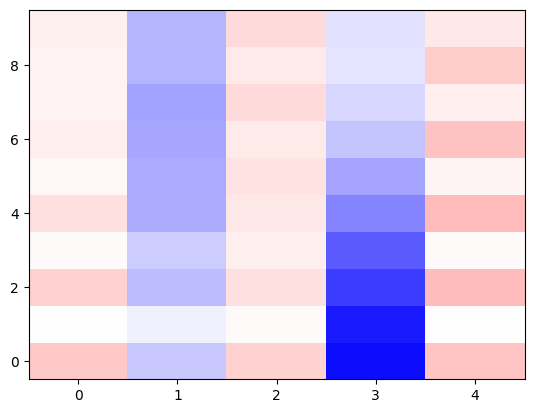

In [3]:
from ropt_aqc.pxp_model import test_magnetisation_evolution

time_steps=10
# binary = '10101010100101010101'
binary = '101001'

state_quimb = test_magnetisation_evolution(binary, num_sites, num_steps, time_steps)

In [4]:
from ropt_aqc.pxp_model import name_layered_gates

layered_gates = BrickwallCircuit.to_layered_gate_list(model_first_order)
named_layered_gates = name_layered_gates(layered_gates)
print(f"Layered gates:", named_layered_gates)

Layered gates: [[(array([[[[ 0.99718882+0.j        ,  0.        +0.j        ],
         [ 0.        -0.07492971j,  0.        +0.j        ]],

        [[ 0.        +0.j        ,  0.99718882+0.j        ],
         [ 0.        +0.j        ,  0.        +0.07492971j]]],


       [[[ 0.        -0.07492971j,  0.        +0.j        ],
         [ 0.99718882+0.j        ,  0.        +0.j        ]],

        [[ 0.        +0.j        ,  0.        -0.07492971j],
         [ 0.        +0.j        , -0.99718882+0.j        ]]]]), (np.int64(0), np.int64(1)), 'G_L0_G0'), (array([[[[ 0.99929696+0.j        ,  0.        +0.j        ],
         [ 0.        -0.03749121j,  0.        +0.j        ]],

        [[ 0.        +0.j        ,  0.99929696+0.j        ],
         [ 0.        +0.j        ,  0.        +0.03749121j]]],


       [[[ 0.        -0.03749121j,  0.        +0.j        ],
         [ 0.99929696+0.j        ,  0.        +0.j        ]],

        [[ 0.        +0.j        ,  0.        -0.03749121j],
      

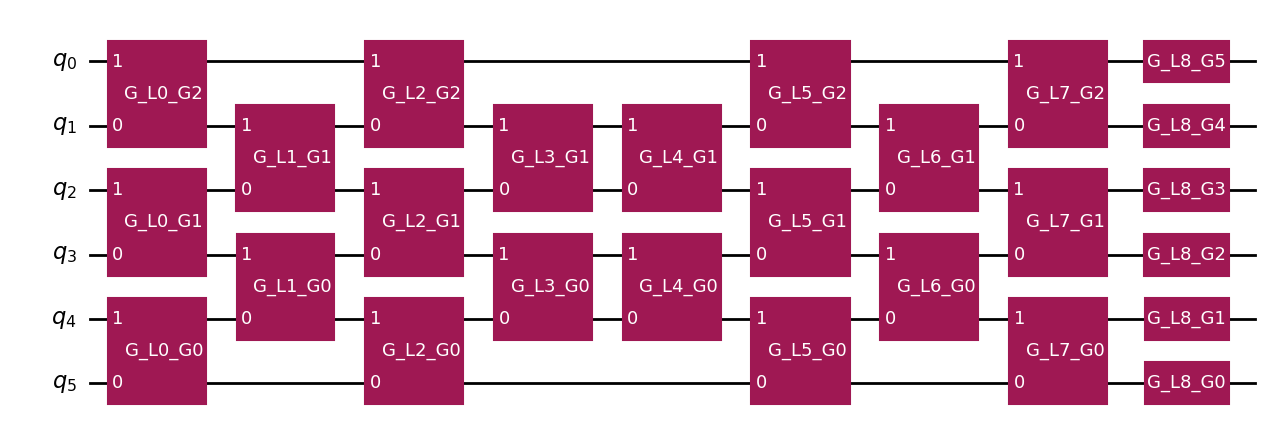

In [5]:
from ropt_aqc.circuit_building import remap_layered_gate_indices, transform_layered_gates_to_qc_with_names

layered_gates_remapped = remap_layered_gate_indices(named_layered_gates, num_sites, qubit_direction="left-to-right")
remapped_circuit = transform_layered_gates_to_qc_with_names(num_sites, layered_gates_remapped)
remapped_circuit.draw('mpl')

In [6]:
original_depth = remapped_circuit.depth()
print(original_depth)

9


In [7]:
from qiskit import transpile
transpiled_circuit = transpile(remapped_circuit, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
transpiled_circuit.draw('mpl')
print(transpiled_circuit.depth())

46


In [8]:
from qiskit.transpiler import CouplingMap
from qiskit import transpile

def generate_linear_coupling_map(num_qubits):

    coupling_list = [[i, i + 1] for i in range(num_qubits - 1)]
    
    return CouplingMap(couplinglist=coupling_list)

linear_coupling_map = generate_linear_coupling_map(num_sites)

transpiled_circuit = transpile(remapped_circuit, basis_gates=['cx', 'rz', 'sx'], coupling_map=linear_coupling_map, optimization_level=3)
transpiled_circuit.draw('mpl')
print(transpiled_circuit.depth())

43


In [9]:
from ropt_aqc.pxp_model import test_magnetisation_qiskit

# state_qiskit = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_remapped=layered_gates_remapped)

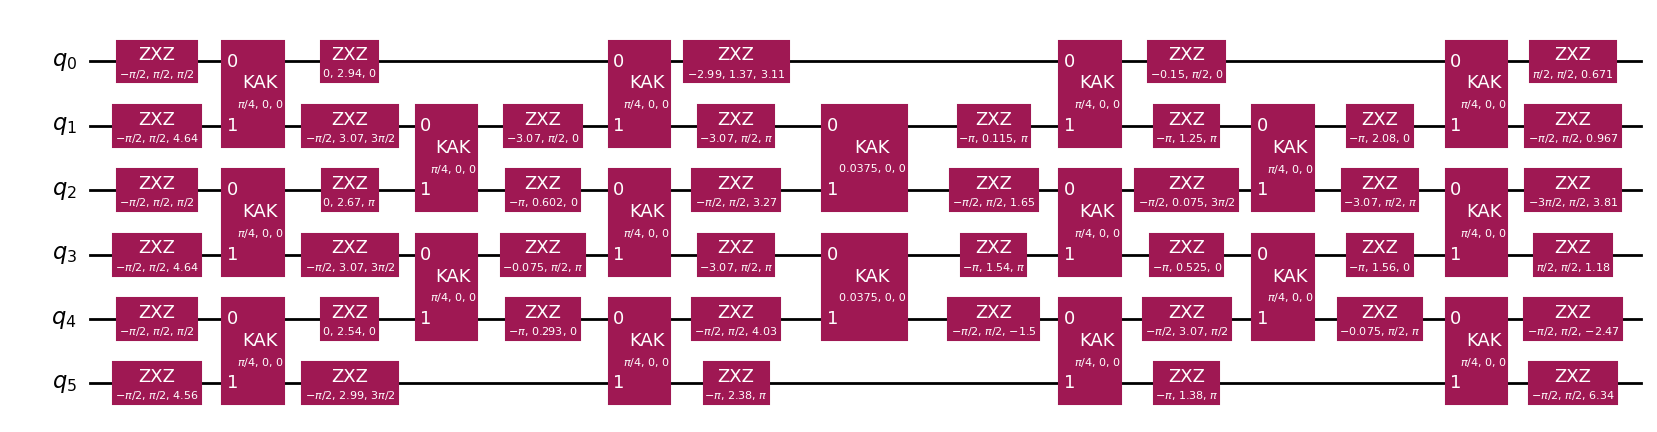

In [10]:
# generate ansatz from circuit
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    remapped_circuit, parameter_name="x"
)
aqc_ansatz_original = aqc_ansatz.assign_parameters(aqc_initial_parameters)
aqc_ansatz_original.draw("mpl", fold=-1)
# aqc_ansatz_original.draw("mpl").savefig('Figures/initial_circuit_AQC-u_PXP_1step.pdf')

In [11]:
initial_aqc_depth = aqc_ansatz.depth()
print(initial_aqc_depth)

15


  0%|          | 0/10 [00:00<?, ?it/s]

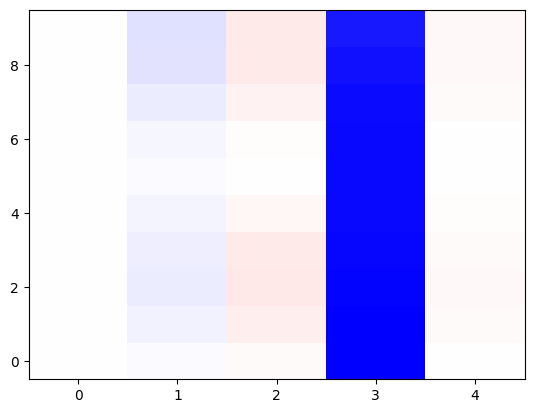

In [12]:
from ropt_aqc.pxp_model import convert_qiskit_layers_to_gate_tensors

state_qiskit = test_magnetisation_qiskit(num_sites, binary, time_steps, qc=remapped_circuit)

In [13]:
from ropt_aqc.pxp_model import pxp_hamiltonian_sparse

hamiltonian = pxp_hamiltonian_sparse(num_sites)
print(hamiltonian)

SparsePauliOp(['XIIIII', 'XIIIII', 'XZIIII', 'XZIIII', 'IXIIII', 'ZXIIII', 'IXZIII', 'ZXZIII', 'IIXIII', 'IZXIII', 'IIXZII', 'IZXZII', 'IIIXII', 'IIZXII', 'IIIXZI', 'IIZXZI', 'IIIIXI', 'IIIZXI', 'IIIIXZ', 'IIIZXZ', 'IIIIIX', 'IIIIZX', 'IIIIIX', 'IIIIZX'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
 0.25+0.j, 0.25+0.j, 0.25+0.j])


  0%|          | 0/10 [00:00<?, ?it/s]

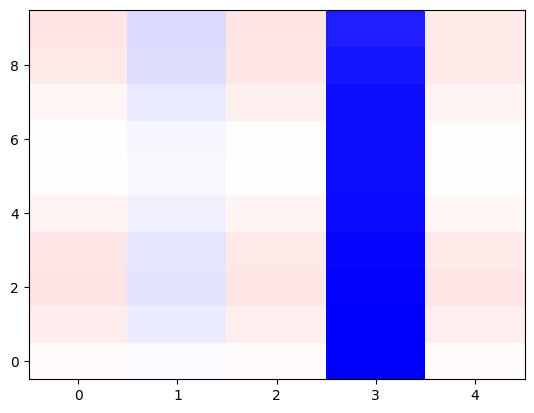

In [14]:
state_initial = test_magnetisation_qiskit(num_sites, binary, time_steps, qc=aqc_ansatz_original)

This single Trotter step circuit will be repeated 256 times:


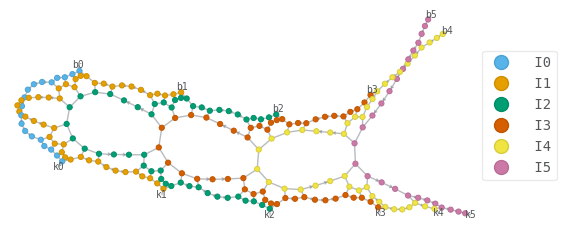

max_tdiff=1.49e-08:   1%|1         | 1/100 [00:00<00:26,  3.75it/s]

│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│4│3│3│3│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │


In [15]:
from ropt_aqc.pxp_model import generate_reference_mpo

aqc_target_log2_num_trotter_steps = 8
aqc_target_mpo, aqc_target_step_circuit = generate_reference_mpo(final_time, aqc_target_log2_num_trotter_steps, hamiltonian)

In [16]:
# set up quimb
from functools import partial
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax", 
)

In [ ]:
from scipy.optimize import OptimizeResult
import numpy as np

def adam(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=1e-3,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    startiter=0,
    maxiter=100_000,
    callback=None,
    **kwargs,
):
    """``scipy.optimize.minimize`` compatible implementation of ADAM -
    [http://arxiv.org/pdf/1412.6980.pdf].
    Adapted from https://github.com/HIPS/autograd/blob/master/autograd/misc/optimizers.py.
    """
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        val, g = fun(x)

        intermediate_result = OptimizeResult(
            x=x, fun=val, jac=g, nit=i, nfev=i, success=True, message="Intermediate result"
        )
        if callback is not None:
            try:
                callback(intermediate_result)
            except StopIteration:
                return OptimizeResult(
                    x=x, fun=val, jac=g, nit=i, nfev=i, success=True, status=99,
                    message="Desired cost reached early"
                )

        m = (1 - beta1) * g + beta1 * m  # first  moment estimate.
        v = (1 - beta2) * (g**2) + beta2 * v  # second moment estimate.
        mhat = m / (1 - beta1**(i + 1))  # bias correction.
        vhat = v / (1 - beta2**(i + 1))
        x = x - learning_rate * mhat / (np.sqrt(vhat) + eps)

    return OptimizeResult(
        x=x, fun=val, jac=g, nit=i + 1, nfev=i + 1, success=True, status=1,
        message="Max iterations reached"
    )

# Complete optimisation of ansatz

In [ ]:
# Optimise with respect to fidelity
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

objective = MaximizeUnitaryFidelity(aqc_target_mpo, aqc_ansatz, simulator_settings)

stopping_point = 1e-4

# def my_loss_function(*args):
#     val, grad = objective.loss_function(*args)

#     # Ensure val is a float (not quimb.Tensor or jax.Array)
#     val = float(val) if hasattr(val, "item") else val
#     grad = jnp.asarray(grad)

#     print(f"Evaluating loss function: {1 - val:.8}")
#     return val, grad

def my_loss_function(x):
    val, grad = objective.loss_function(x)
    print(f"Evaluating fidelity: {1 - val:.8f}")
    return float(val), np.array(grad)


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    my_loss_function,
    aqc_initial_parameters,
    # method="L-BFGS-B",
    method = adam,
    jac=False,
    options={"maxiter": 100},
    callback=callback,
)

if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Evaluating fidelity: 0.52458275
Intermediate result: Fidelity 0.52458275
Evaluating fidelity: 0.53787248
Intermediate result: Fidelity 0.53787248
Evaluating fidelity: 0.55109745
Intermediate result: Fidelity 0.55109745
Evaluating fidelity: 0.56418436
Intermediate result: Fidelity 0.56418436
Evaluating fidelity: 0.57717510
Intermediate result: Fidelity 0.5771751
Evaluating fidelity: 0.59011357
Intermediate result: Fidelity 0.59011357
Evaluating fidelity: 0.60301113
Intermediate result: Fidelity 0.60301113
Evaluating fidelity: 0.61586374
Intermediate result: Fidelity 0.61586374
Evaluating fidelity: 0.62865915
Intermediate result: Fidelity 0.62865915
Evaluating fidelity: 0.64137945
Intermediate result: Fidelity 0.64137945
Evaluating fidelity: 0.65400308
Intermediate result: Fidelity 0.65400308
Evaluating fidelity: 0.66651080
Intermediate result: Fidelity 0.6665108
Evaluating fidelity: 0.67889038
Intermediate result: Fidelity 0.67889038
Evaluating fidelity: 0.69113630
Intermediate result: 

=== Complete Optimised Circuit ===


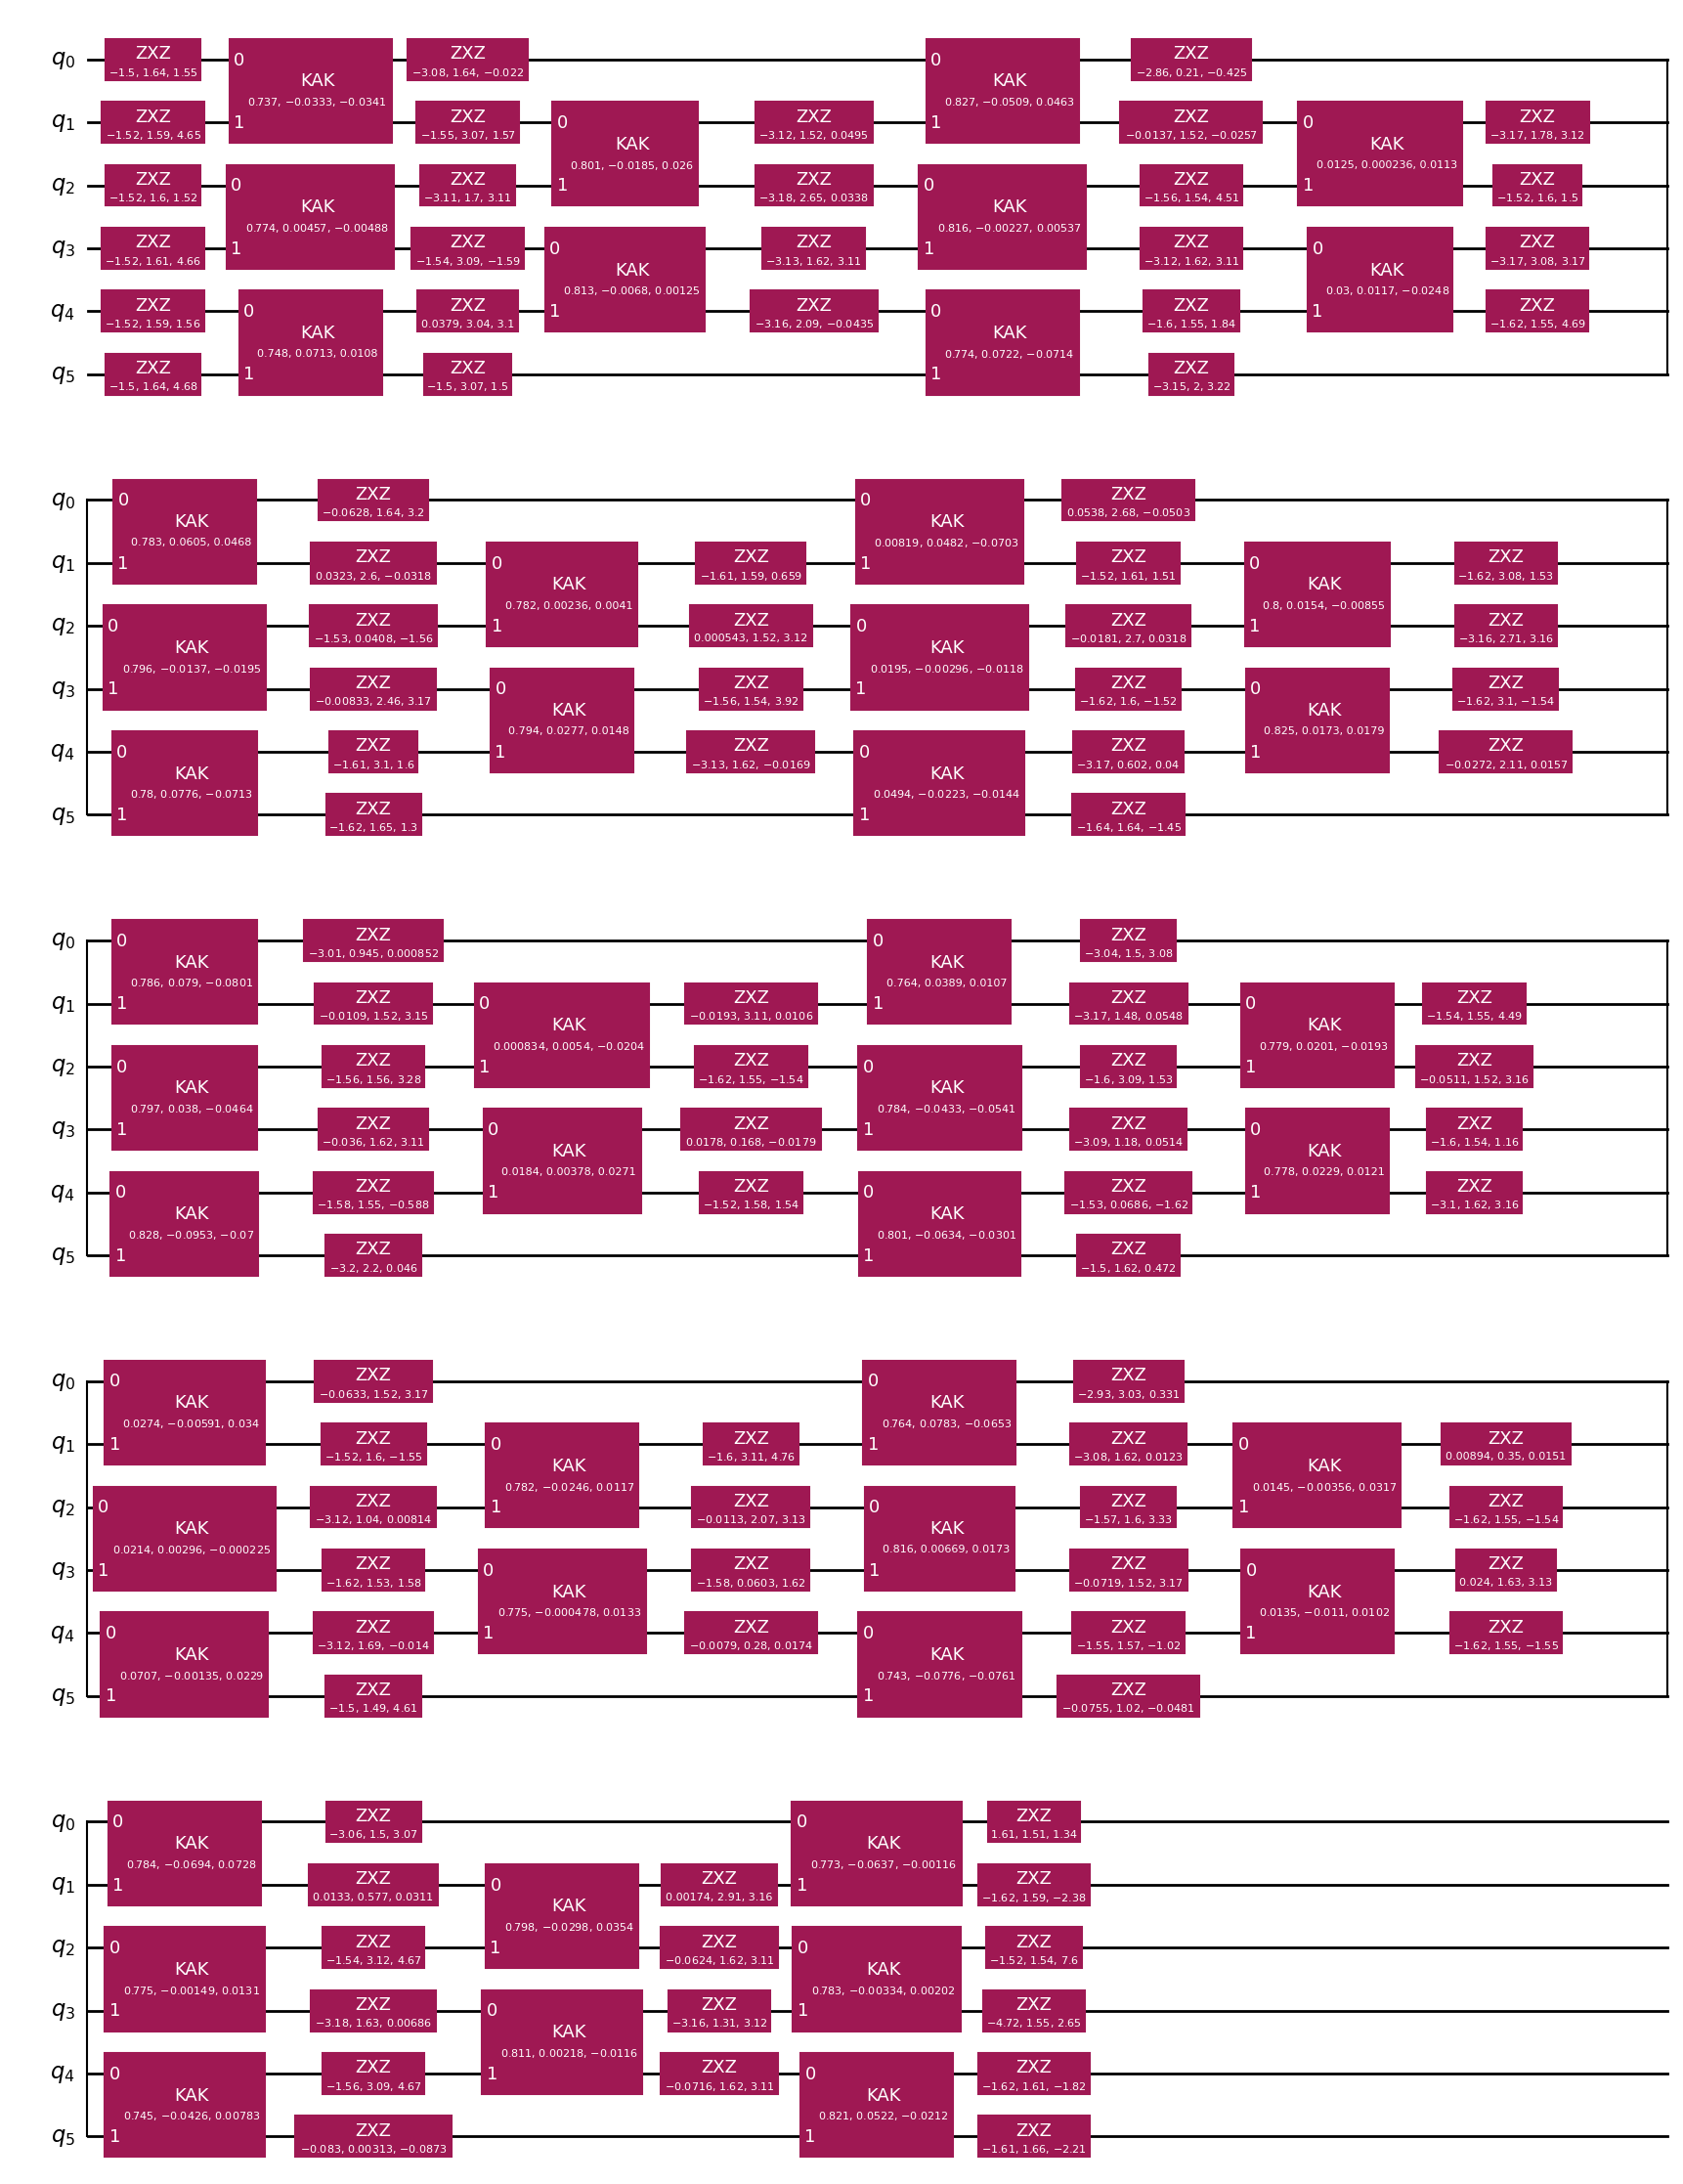

In [ ]:
# optimised circuit 
aqc_optimised_block = aqc_ansatz.assign_parameters(aqc_final_parameters)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block.draw("mpl")

In [ ]:
optimised_aqc_depth = aqc_optimised_block.depth()
print(optimised_aqc_depth)

39


  0%|          | 0/10 [00:00<?, ?it/s]

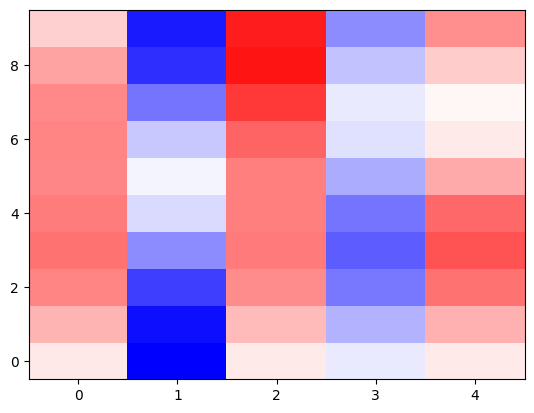

In [ ]:
layered_gates_optimised = convert_qiskit_layers_to_gate_tensors(aqc_optimised_block)
state_optimised = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_optimised)

In [ ]:
from ropt_aqc.pxp_model import calcualte_initial_final_Frobenius

initial_fidelity, final_fidelity = calcualte_initial_final_Frobenius(num_sites, aqc_target_step_circuit, aqc_target_log2_num_trotter_steps, aqc_optimised_block, initial_qc=remapped_circuit)

Initial Frobenius inner product: 0.52458398
Final Frobenius inner product: 0.99871656


# Forward Optimisation of Ansatz

In [54]:
# Now slice and compress
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals = range(1, 15)
df, aqc_ansatz, aqc_final_parameters = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, aqc_target_mpo, N_vals, simulator_settings, num_steps)


=== Optimising with N = 1 layers ===
Evaluating fidelity: 0.00042058
Intermediate result: Fidelity 0.00042057788
Evaluating fidelity: 0.00042796
Intermediate result: Fidelity 0.00042796493
Evaluating fidelity: 0.00043544
Intermediate result: Fidelity 0.00043544115
Evaluating fidelity: 0.00044301
Intermediate result: Fidelity 0.00044300879
Evaluating fidelity: 0.00045067
Intermediate result: Fidelity 0.00045067017
Evaluating fidelity: 0.00045843
Intermediate result: Fidelity 0.0004584277
Evaluating fidelity: 0.00046628
Intermediate result: Fidelity 0.00046628381
Evaluating fidelity: 0.00047424
Intermediate result: Fidelity 0.00047424104
Evaluating fidelity: 0.00048230
Intermediate result: Fidelity 0.00048230197
Evaluating fidelity: 0.00049047
Intermediate result: Fidelity 0.00049046923
Evaluating fidelity: 0.00049875
Intermediate result: Fidelity 0.00049874552
Evaluating fidelity: 0.00050713
Intermediate result: Fidelity 0.00050713359
Evaluating fidelity: 0.00051564
Intermediate result

In [ ]:
# Optimise with respect to fidelity
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

objective = MaximizeUnitaryFidelity(aqc_target_mpo, aqc_ansatz, simulator_settings)

stopping_point = 1e-4

# def my_loss_function(*args):
#     val, grad = objective.loss_function(*args)

#     # Ensure val is a float (not quimb.Tensor or jax.Array)
#     val = float(val) if hasattr(val, "item") else val
#     grad = jnp.asarray(grad)

#     print(f"Evaluating loss function: {1 - val:.8}")
#     return val, grad

def my_loss_function(x):
    val, grad = objective.loss_function(x)
    print(f"Evaluating fidelity: {1 - val:.8f}")
    return float(val), np.array(grad)


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    my_loss_function,
    aqc_initial_parameters,
    # method="L-BFGS-B",
    method = adam,
    jac=False,
    options={"maxiter": 100},
    callback=callback,
)

if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Evaluating fidelity: 0.52458275
Intermediate result: Fidelity 0.52458275
Evaluating fidelity: 0.53787248
Intermediate result: Fidelity 0.53787248
Evaluating fidelity: 0.55109745
Intermediate result: Fidelity 0.55109745
Evaluating fidelity: 0.56418436
Intermediate result: Fidelity 0.56418436
Evaluating fidelity: 0.57717510
Intermediate result: Fidelity 0.5771751
Evaluating fidelity: 0.59011357
Intermediate result: Fidelity 0.59011357
Evaluating fidelity: 0.60301113
Intermediate result: Fidelity 0.60301113
Evaluating fidelity: 0.61586374
Intermediate result: Fidelity 0.61586374
Evaluating fidelity: 0.62865915
Intermediate result: Fidelity 0.62865915
Evaluating fidelity: 0.64137945
Intermediate result: Fidelity 0.64137945
Evaluating fidelity: 0.65400308
Intermediate result: Fidelity 0.65400308
Evaluating fidelity: 0.66651080
Intermediate result: Fidelity 0.6665108
Evaluating fidelity: 0.67889038
Intermediate result: Fidelity 0.67889038
Evaluating fidelity: 0.69113630
Intermediate result: 

In [ ]:
import pandas as pd
file_path_PXP=f'/Users/aag/Documents/ropt-aqc/PXP/results/AQC_unitary_PXP_results_{num_sites}q_{final_time}_{num_steps}steps_forward.csv'
df.to_csv(file_path_PXP, index=False, header=True)
# df.to_csv(file_path_PXP, index=False, mode="a", header=False)

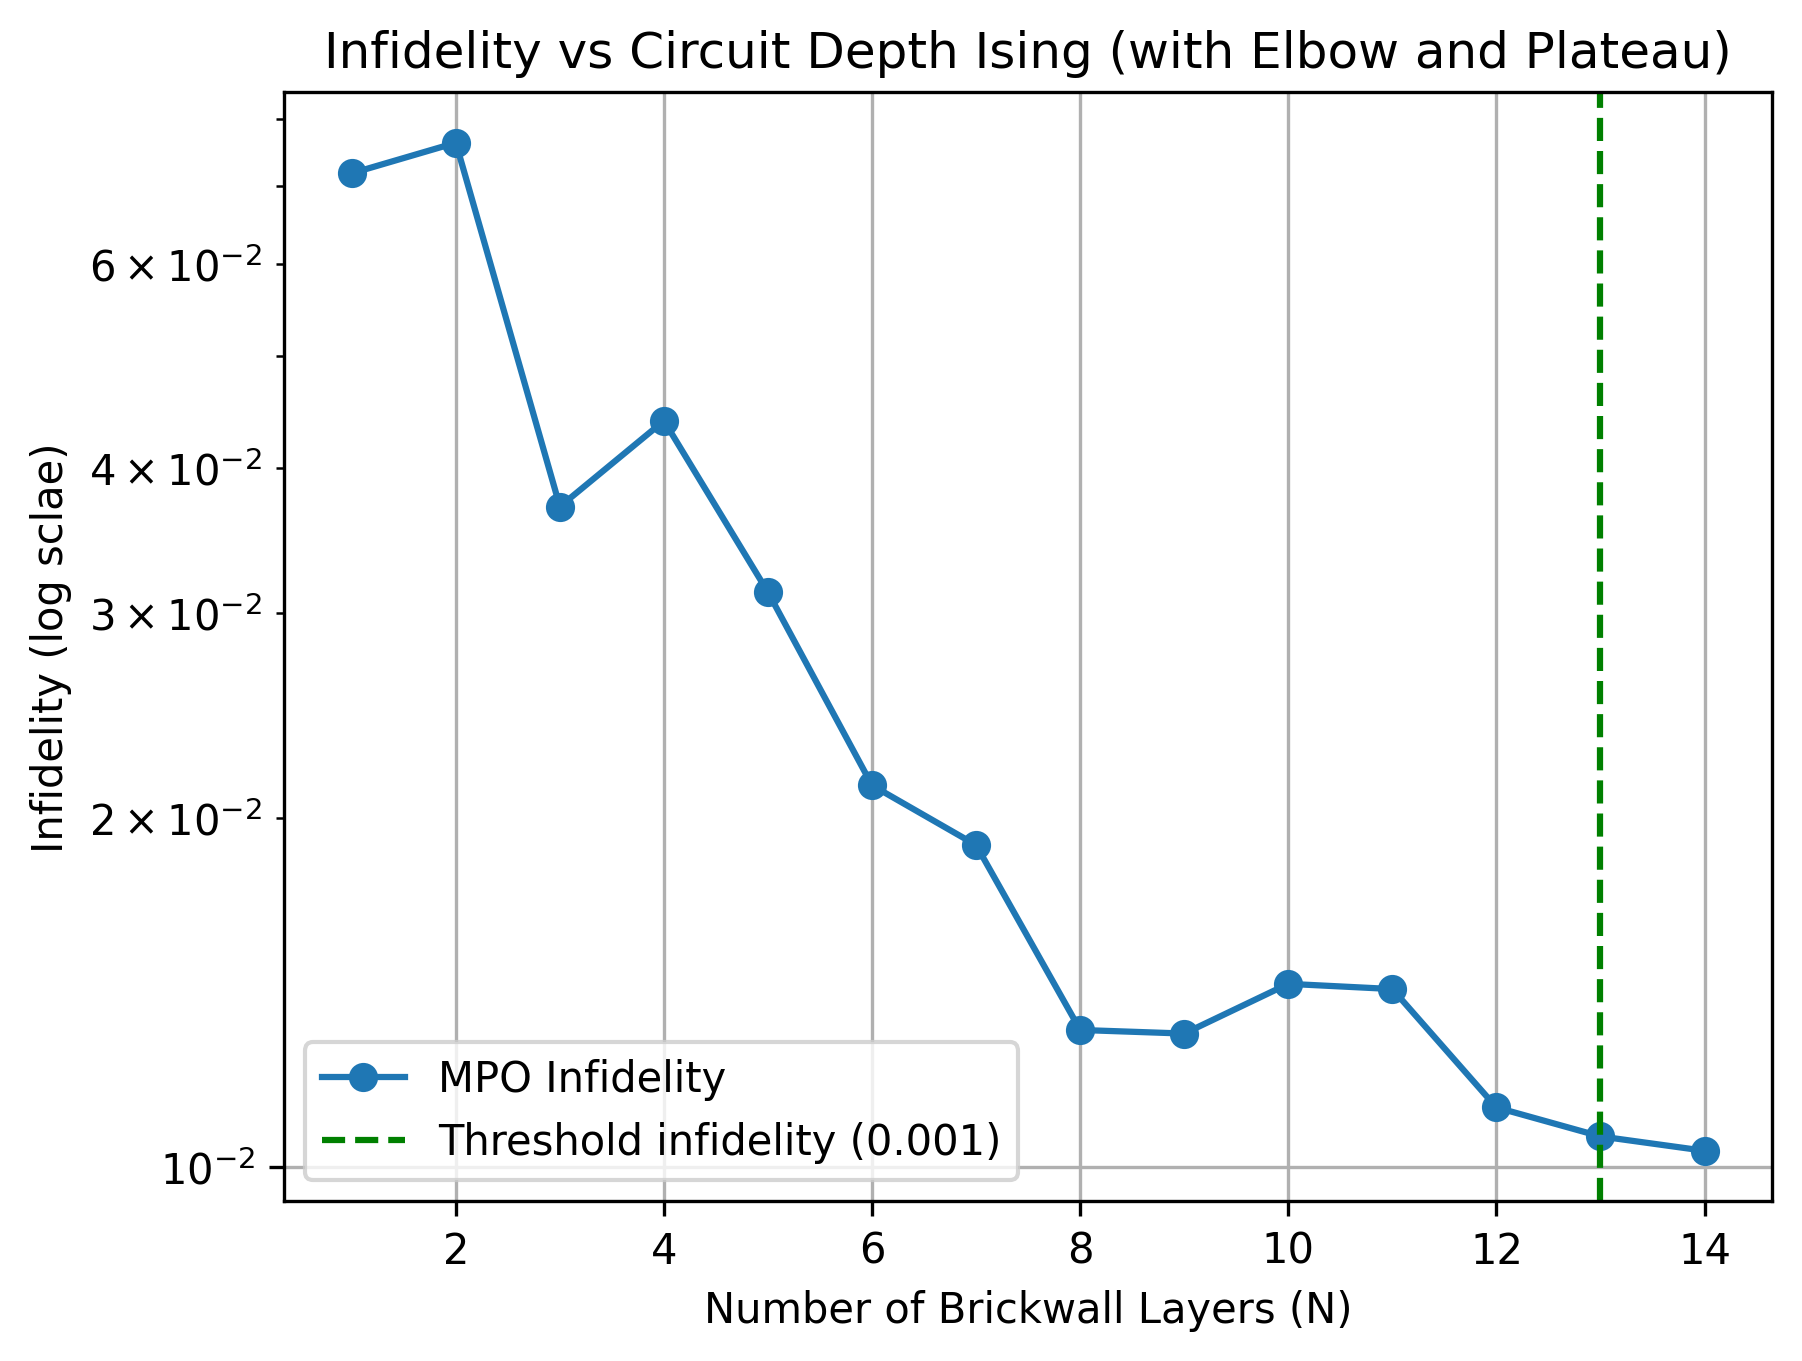


🔍 Suggested optimal compression depth: N = 13.0


In [55]:
from ropt_aqc.brickwall_opt import plot_fidelity

method = 'AQC-unitary'
elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', final_time, 1e-3, method, 'PXP', save_path=True)

In [56]:
# Compress circuit
from ropt_aqc.comparison_methods import compress_AQC_unitary

# N_vals = [int(plateau_N)]
N_vals = [12]
df_compressed, aqc_ansatz_compressed, aqc_final_parameters_compressed = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, aqc_target_mpo, N_vals, simulator_settings, num_steps)


=== Optimising with N = 12 layers ===
Evaluating fidelity: 0.01720095
Intermediate result: Fidelity 0.017200955
Evaluating fidelity: 0.01811011
Intermediate result: Fidelity 0.018110108
Evaluating fidelity: 0.01903057
Intermediate result: Fidelity 0.019030571
Evaluating fidelity: 0.01996228
Intermediate result: Fidelity 0.019962281
Evaluating fidelity: 0.02090518
Intermediate result: Fidelity 0.020905177
Evaluating fidelity: 0.02185933
Intermediate result: Fidelity 0.021859327
Evaluating fidelity: 0.02282483
Intermediate result: Fidelity 0.022824835
Evaluating fidelity: 0.02380177
Intermediate result: Fidelity 0.023801774
Evaluating fidelity: 0.02479023
Intermediate result: Fidelity 0.024790231
Evaluating fidelity: 0.02579034
Intermediate result: Fidelity 0.025790339
Evaluating fidelity: 0.02680226
Intermediate result: Fidelity 0.026802264
Evaluating fidelity: 0.02782619
Intermediate result: Fidelity 0.027826186
Evaluating fidelity: 0.02886229
Intermediate result: Fidelity 0.028862295

In [58]:
from qiskit import transpile

print(aqc_ansatz_compressed.depth())
transpiled_circuit_aqc = transpile(aqc_ansatz_compressed, basis_gates=['cx', 'rz', 'sx'],optimization_level=3)
print(transpiled_circuit_aqc.depth())

12
104


In [ ]:
print("=== Compressed Optimised Circuit ===")
print(aqc_ansatz_compressed.depth())
param_binding = {param: value for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed)}
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
# aqc_optimised_compressed.draw("mpl").savefig('optimised_circuit_hybrid-AQC-u_PXP.pdf')
# print(aqc_optimised_compressed.depth())

In [ ]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_unitary_parameters_Ising.csv', index=False)

In [ ]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Transpiled depth of compressed circuit: {transpiled_circuit_aqc.depth()}")
print(f"Compression ratio: {initial_aqc_depth / aqc_optimised_compressed.depth()}")
print(f"Transpiled Compression ratio: {transpiled_circuit.depth() / transpiled_circuit_aqc.depth()}")

In [ ]:
layered_gates_compressed = convert_qiskit_layers_to_gate_tensors(aqc_optimised_compressed)
state_compressed = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_compressed)

# Reverse Compression Ansatz

In [17]:
from ropt_aqc.comparison_methods import compress_AQC_unitary_reverse

df, aqc_truncated, aqc_final_parameters_reverse = compress_AQC_unitary_reverse(aqc_ansatz, aqc_initial_parameters, initial_aqc_depth, aqc_target_mpo, simulator_settings, fidelity_threshold=0.97)


=== Reverse Compression: Optimising with N = 15 layers ===
N = 15 → Truncated circuit has 180 parameters
[Instruction(name='zxz', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2])]), Instruction(name='zxz', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5])]), Instruction(name='zxz', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8])]), Instruction(name='zxz', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(x[9]), ParameterVectorElement(x[10]), ParameterVectorElement(x[11])]), Instruction(name='zxz', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(x[12]), ParameterVectorElement(x[13]), ParameterVectorElement(x[14])]), Instruction(name='zxz', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(x[15]), ParameterVectorElement(x[16]), Parame

In [ ]:
from qiskit import transpile

print(aqc_truncated.depth())
transpiled_circuit_aqc = transpile(aqc_truncated, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

5
42


In [ ]:
import pandas as pd
file_path_PXP=f'/Users/aag/Documents/ropt-aqc/PXP/results/AQC_unitary_PXP_results_{num_sites}q_{final_time}_{num_steps}steps_reverse.csv'
df.to_csv(file_path_PXP, index=False, header=True)
# df.to_csv(file_path_PXP, index=False, mode="a", header=False)

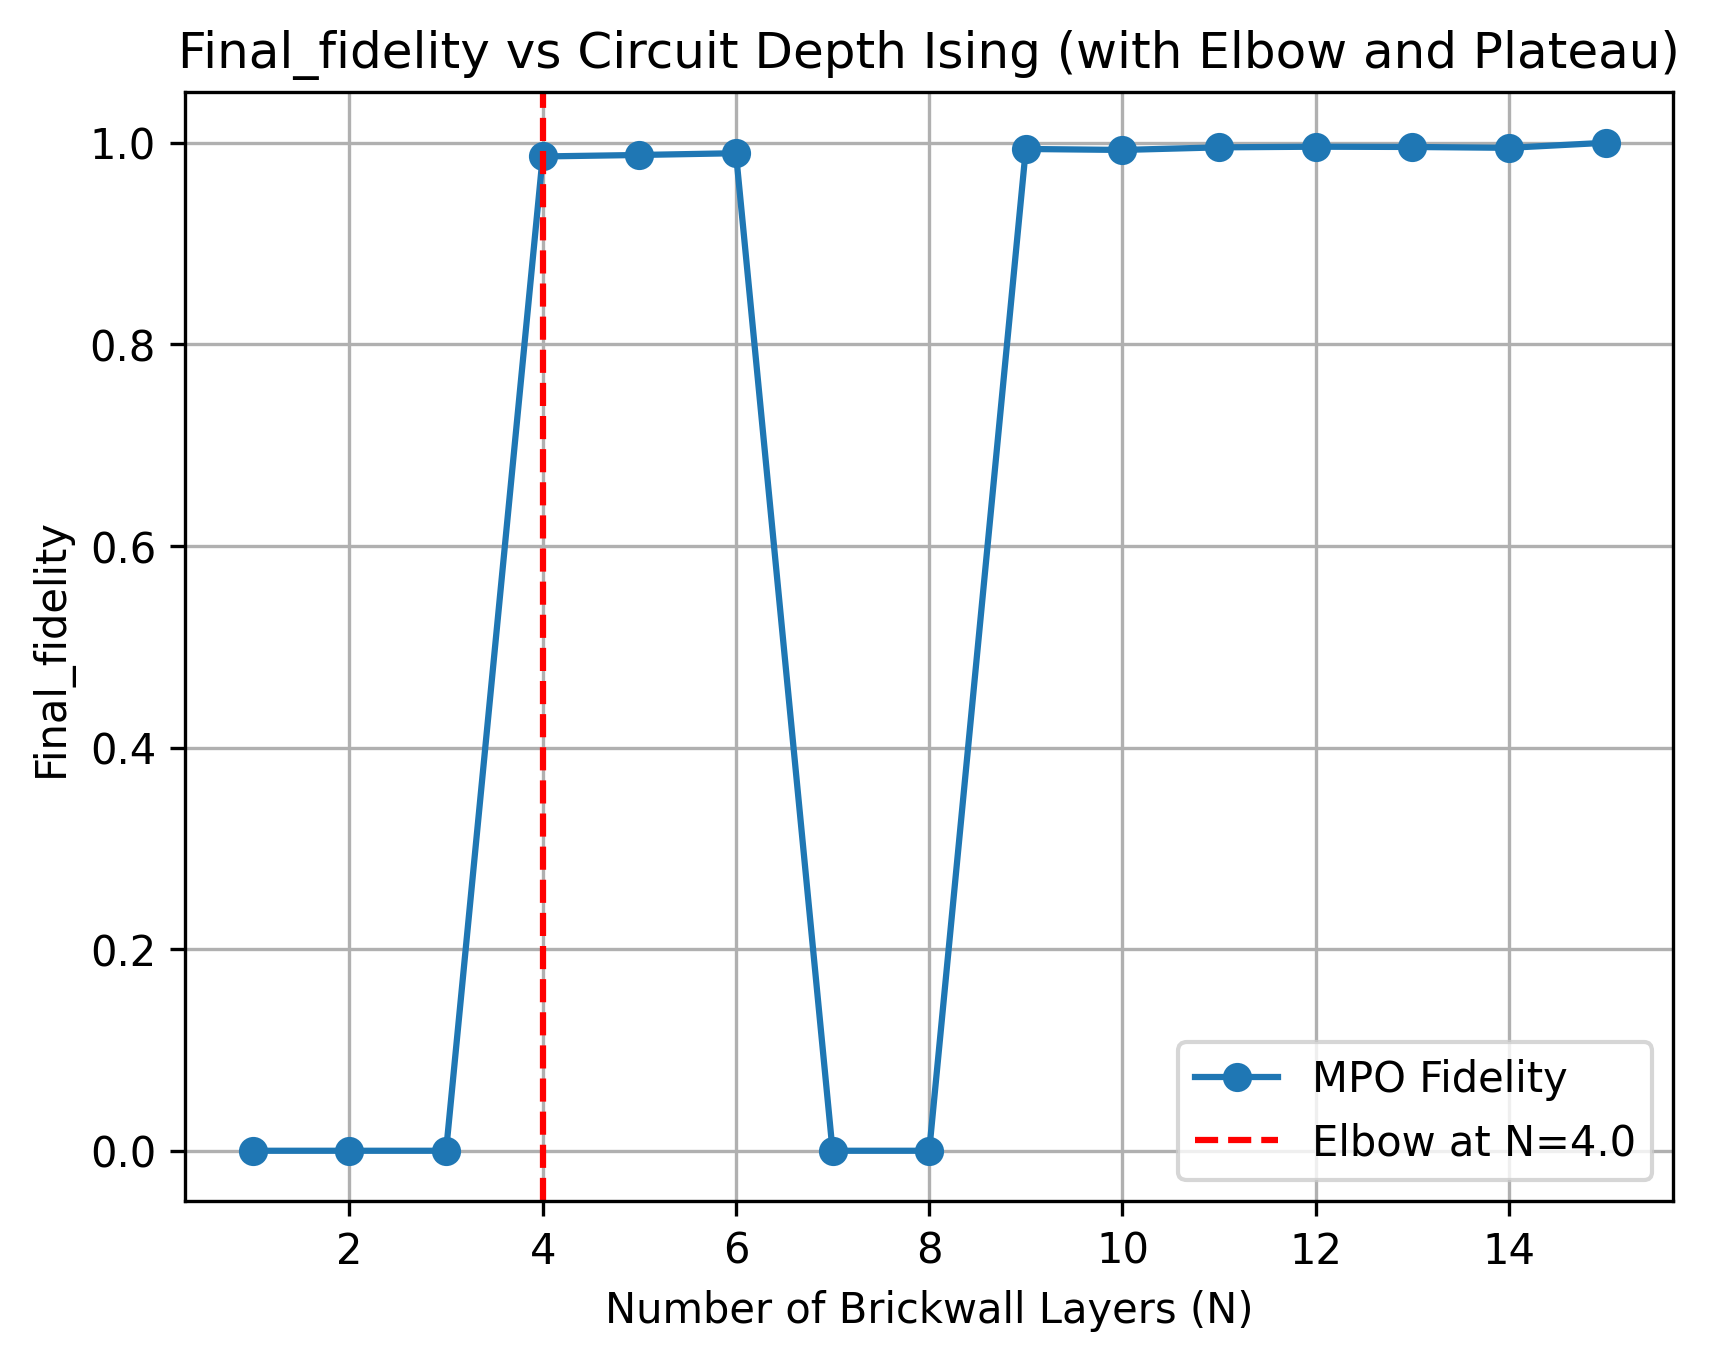


🔍 Suggested optimal compression depth: N = None


In [ ]:
from ropt_aqc.brickwall_opt import plot_fidelity
# df_reverse = df.sort_values("circuit_layers", ascending=True)
method = 'AQC-unitary-reverse'
elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', final_time, 1e-3, method, 'PXP', save_path=True)

=== Compressed Optimised Circuit ===


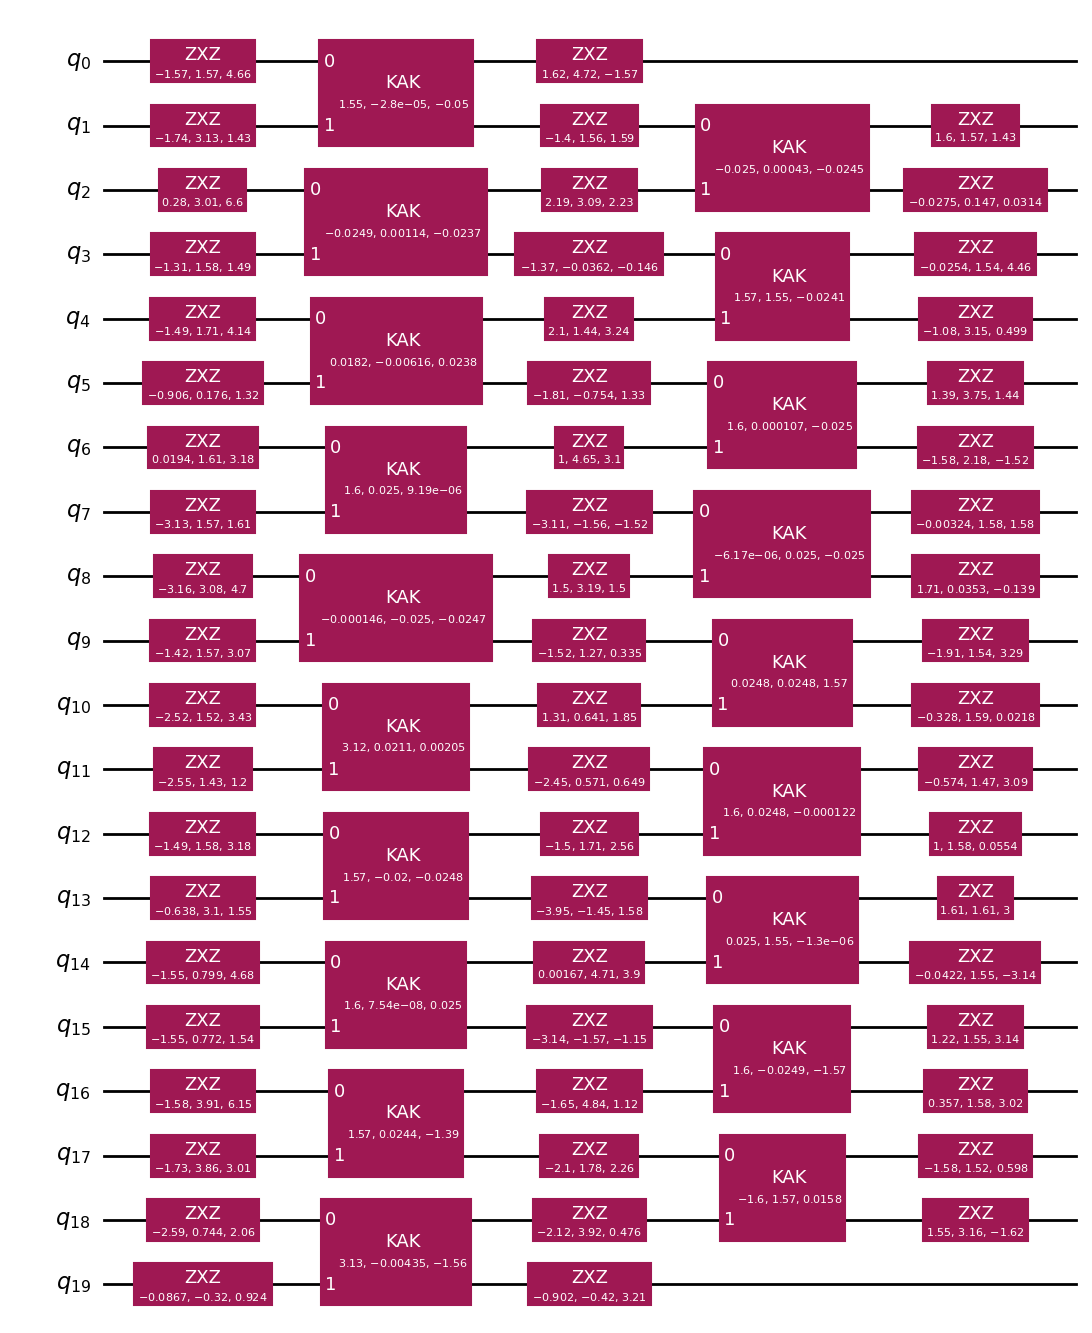

In [ ]:
print("=== Compressed Optimised Circuit ===")

param_binding = {param: value for param, value in zip(aqc_truncated.parameters, aqc_final_parameters_reverse)}
aqc_optimised_compressed = aqc_truncated.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
# aqc_optimised_compressed.draw("mpl").savefig('Figures/optimised_circuit_AQC-u_PXP.pdf')

In [ ]:
print(aqc_optimised_compressed.depth())
transpiled_circuit_aqc = transpile(aqc_optimised_compressed, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

5


In [ ]:
from ropt_aqc.pxp_model import calcualte_initial_final_Frobenius

initial_fidelity1, final_fidelity1 = calcualte_initial_final_Frobenius(num_sites, aqc_target_step_circuit, aqc_target_log2_num_trotter_steps, aqc_optimised_compressed, initial_qc=remapped_circuit)

Initial Frobenius inner product: 0.93218519
Final Frobenius inner product: 0.99998986


In [ ]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_truncated.parameters, aqc_final_parameters_reverse):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_unitary_parameters_Ising.csv', index=False)


=== Compressed Optimised Parameters ===
x[0]: -1.570968
x[1]: 1.574903
x[2]: 4.662138
x[3]: -1.743854
x[4]: 3.134209
x[5]: 1.430930
x[6]: 0.279637
x[7]: 3.007175
x[8]: 6.601256
x[9]: -1.310588
x[10]: 1.584705
x[11]: 1.492322
x[12]: -1.485910
x[13]: 1.705298
x[14]: 4.136614
x[15]: -0.906455
x[16]: 0.176176
x[17]: 1.315535
x[18]: 0.019410
x[19]: 1.610085
x[20]: 3.179057
x[21]: -3.134410
x[22]: 1.573037
x[23]: 1.606896
x[24]: -3.158863
x[25]: 3.077181
x[26]: 4.695663
x[27]: -1.422765
x[28]: 1.572666
x[29]: 3.071873
x[30]: -2.521500
x[31]: 1.515967
x[32]: 3.427484
x[33]: -2.554481
x[34]: 1.431939
x[35]: 1.198282
x[36]: -1.486925
x[37]: 1.584411
x[38]: 3.176389
x[39]: -0.638308
x[40]: 3.102863
x[41]: 1.551193
x[42]: -1.547926
x[43]: 0.798749
x[44]: 4.679449
x[45]: -1.546060
x[46]: 0.771812
x[47]: 1.536880
x[48]: -1.575828
x[49]: 3.905470
x[50]: 6.149011
x[51]: -1.732567
x[52]: 3.855076
x[53]: 3.008943
x[54]: -2.589386
x[55]: 0.743593
x[56]: 2.058693
x[57]: -0.086696
x[58]: -0.319675
x[59]:

In [ ]:
print(f"Number of parameters in ansatz: {len(aqc_truncated.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Transpiled depth of compressed circuit: {transpiled_circuit_aqc.depth()}")
print(f"Compression ratio: {initial_aqc_depth / aqc_optimised_compressed.depth()}")
print(f"Transpiled Compression ratio: {transpiled_circuit.depth() / transpiled_circuit_aqc.depth()}")

Number of parameters in ansatz: 177
Physical depth of compressed circuit: 4
Transpiled depth of compressed circuit: 28
Compression ratio: 3.75
Transpiled Compression ratio: 1.6071428571428572


  0%|          | 0/10 [00:00<?, ?it/s]

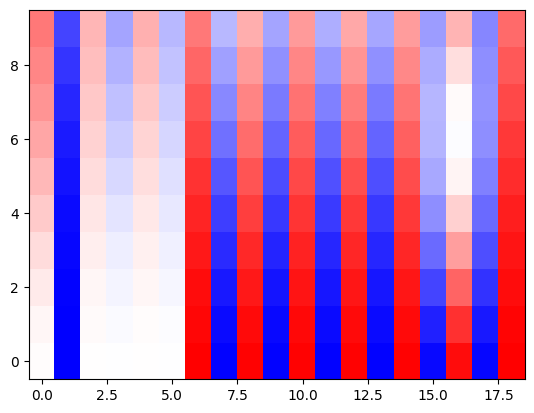

In [ ]:
layered_gates_compressed = convert_qiskit_layers_to_gate_tensors(aqc_optimised_compressed)
state_compressed = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_compressed)

In [ ]:
# Compress single Trotter step with different n layers 
compressed_circuit_dict = {}

for depth in [5, 6, 7, 8]:
    print(f"\n=== Compressing with {depth} layers ===")
    
    df_compressed, aqc_ansatz_compressed, aqc_initial_parameters_compressed, aqc_final_parameters_compressed = compress_AQC_unitary(
        aqc_ansatz,
        aqc_initial_parameters,
        aqc_target_mpo,
        [depth],  # must be a list
        simulator_settings,
        num_steps
    )

    param_binding = {
        param: value for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed)
    }
    aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(param_binding)

    # Calculate fidelity for the compressed circuit
    initial_fidelity1, final_fidelity1 = calcualte_initial_final_Frobenius(
        num_sites,
        aqc_target_step_circuit,
        aqc_target_log2_num_trotter_steps,
        aqc_optimised_compressed,
        initial_qc=remapped_circuit
    )

    compressed_depth = aqc_optimised_compressed.depth()
    compression_ratio = original_depth / compressed_depth
    label = f"{depth}-layer (×{compression_ratio:.2f})"

    compressed_circuit_dict[label] = aqc_optimised_compressed

    print(f"Number of parameters: {len(aqc_ansatz_compressed.parameters)}")
    print(f"Compressed depth: {compressed_depth}")
    print(f"Compression ratio: {compression_ratio:.2f}")



=== Compressing with 5 layers ===

=== Optimizing with N = 5 layers ===
Evaluating loss function: 0.020786332
Evaluating loss function: 0.11044683
Evaluating loss function: 0.00093178642
Evaluating loss function: 0.14592669
Intermediate result: Fidelity 0.14592669
Evaluating loss function: 0.19223253
Intermediate result: Fidelity 0.19223253
Evaluating loss function: 0.21330152
Intermediate result: Fidelity 0.21330152
Evaluating loss function: 0.4629244
Intermediate result: Fidelity 0.4629244
Evaluating loss function: 0.56005563
Intermediate result: Fidelity 0.56005563
Evaluating loss function: 0.62143918
Evaluating loss function: 0.67736572
Intermediate result: Fidelity 0.67736572
Evaluating loss function: 0.68970445
Evaluating loss function: 0.7979833
Intermediate result: Fidelity 0.7979833
Evaluating loss function: 0.90800364
Intermediate result: Fidelity 0.90800364
Evaluating loss function: 0.92176072
Evaluating loss function: 0.97652607
Intermediate result: Fidelity 0.97652607
Eva

Final Frobenius inner product: 0.99874682
✅ 5-layer (×1.80), step 1, fidelity = 0.99874682
Final Frobenius inner product: 0.99750438
✅ 6-layer (×1.50), step 1, fidelity = 0.99750438
Final Frobenius inner product: 0.99874756
✅ 7-layer (×1.29), step 1, fidelity = 0.99874756
Final Frobenius inner product: 0.99998986
✅ 8-layer (×1.12), step 1, fidelity = 0.99998986
Final Frobenius inner product: 0.99501167
✅ 5-layer (×1.80), step 2, fidelity = 0.99501167
Final Frobenius inner product: 0.99007855
✅ 6-layer (×1.50), step 2, fidelity = 0.99007855
Final Frobenius inner product: 0.9950146
✅ 7-layer (×1.29), step 2, fidelity = 0.99501460
Final Frobenius inner product: 0.9999598
✅ 8-layer (×1.12), step 2, fidelity = 0.99995980
Final Frobenius inner product: 0.9888665
✅ 5-layer (×1.80), step 3, fidelity = 0.98886650
Final Frobenius inner product: 0.97790211
✅ 6-layer (×1.50), step 3, fidelity = 0.97790211
Final Frobenius inner product: 0.98887302
✅ 7-layer (×1.29), step 3, fidelity = 0.98887302
Fi

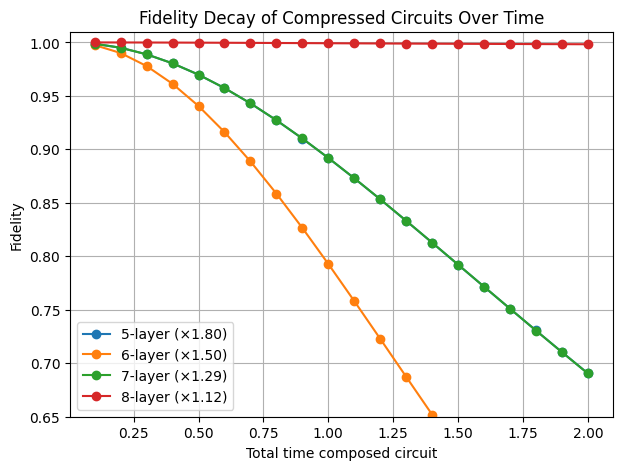

In [ ]:
from ropt_aqc.pxp_model import plot_fidelity_decay_multiple_compressed_circuits

time_points, fidelity_dict = plot_fidelity_decay_multiple_compressed_circuits(
    compressed_circuit_dict=compressed_circuit_dict,
    reference_step_circuit=aqc_target_step_circuit,  # single Trotter step circuit used in training
    final_time=final_time,
    num_sites=num_sites,
    trotter_log2_steps=aqc_target_log2_num_trotter_steps,
    max_steps=20
)


In [ ]:
# Compose single step to n steps
from qiskit import QuantumCircuit
qc_total = QuantumCircuit(num_sites)

n= 20
total_time = n * final_time

for _ in range(n):
    qc_total.compose(aqc_optimised_compressed, inplace=True)


  0%|          | 0/20 [00:00<?, ?it/s]

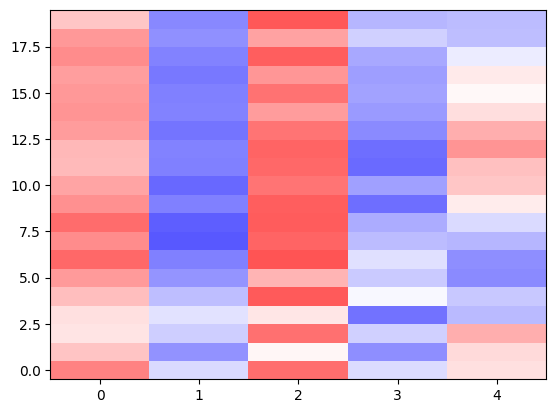

In [ ]:
layered_gates_total = convert_qiskit_layers_to_gate_tensors(qc_total)
state_total = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_total)

In [ ]:
from mpo_lib.models.pxp_model import PXPModel1D
from mpo_lib.circuit.brickwall import BrickwallCircuit

num_sites = 6
num_steps = n
final_time = total_time

total_model_first_order = PXPModel1D.first_order(num_sites, final_time, num_steps)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

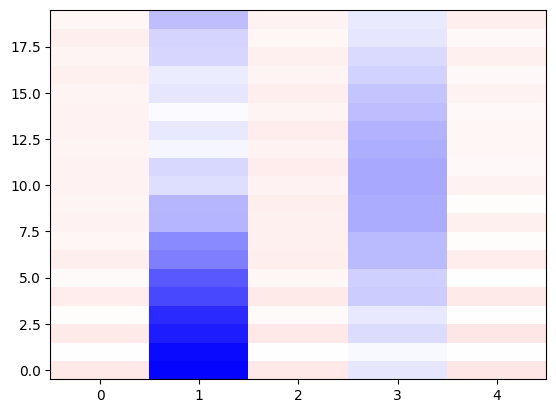

In [ ]:
from mpo_lib.models.pxp_model import test_magnetisation_evolution

time_steps=20

# binary = '101010100101001010101'
binary = '100101'

state_quimb_total = test_magnetisation_evolution(binary, num_sites, num_steps, time_steps)

In [ ]:
layered_gates_total = BrickwallCircuit.to_layered_gate_list(total_model_first_order)
named_layered_gates_total = []

for layer_idx, layer in enumerate(layered_gates_total):
    named_layer = []
    for gate_idx, (gate_tensor, qubits) in enumerate(layer):
        name = f"G_L{layer_idx}_G{gate_idx}"
        named_layer.append((gate_tensor, qubits, name))
        # print(f"{name} -> qubits {qubits}")
    named_layered_gates_total.append(named_layer)

In [ ]:
from ropt_aqc.circuit_building import remap_layered_gate_indices, transform_layered_gates_to_qc_with_names

layered_gates_remapped_total = remap_layered_gate_indices(named_layered_gates_total, num_sites, qubit_direction="left-to-right")
remapped_circuit_total = transform_layered_gates_to_qc_with_names(num_sites, layered_gates_remapped_total)
# remapped_circuit_total.draw('mpl')

M2 diagonalization seems to have failed.  Trying again with transpiled 2-qubit circuit.
Traceback (most recent call last):
  File "/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/qiskit_addon_aqc_tensor/ansatz_generation/from_connectivity.py", line 308, in perform_separation
    d = TwoQubitWeylDecomposition(mat)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/qiskit/synthesis/two_qubit/two_qubit_decompose.py", line 166, in __init__
    self._inner_decomposition = two_qubit_decompose.TwoQubitWeylDecomposition(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
qiskit.exceptions.QiskitError: 'TwoQubitWeylDecomposition: failed to diagonalize M2. Please report this at https://github.com/Qiskit/qiskit-terra/issues/4159. Input: [[Complex { re: 0.15349496701170925, im: -0.46924401554347434 }, Complex { re: -0.15349496701171353, im: 0.46924401554350503 }, Complex { re: 

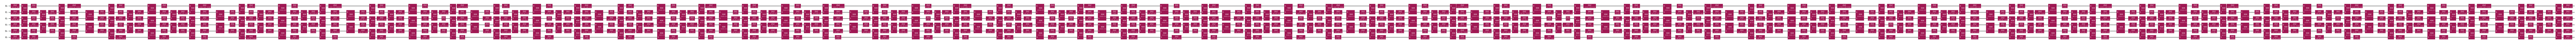

In [ ]:
# generate ansatz from circuit
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz_total, aqc_initial_parameters_total = generate_ansatz_from_circuit(
    remapped_circuit_total, parameter_name="x"
)
aqc_ansatz_original_total = aqc_ansatz_total.assign_parameters(aqc_initial_parameters_total)
aqc_ansatz_original_total.draw("mpl", fold=-1)
# aqc_ansatz_original.draw("mpl").savefig('Figures/initial_circuit_AQC-u_PXP_1step.pdf')

  0%|          | 0/20 [00:00<?, ?it/s]

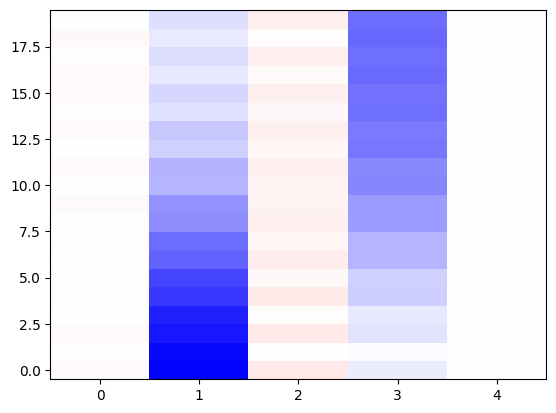

In [ ]:
layered_gates_test = convert_qiskit_layers_to_gate_tensors(remapped_circuit)
state_qiskit = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_test)

In [ ]:
print('Total evolution:', state_total)
print('Ref evolution: ', state_qiskit)

Total evolution: [[-0.82625462  0.98726189  0.98783056 -0.9013881   0.97563169 -0.86598249]
 [-0.3750735   0.93066386  0.94015259 -0.63505009  0.90859284 -0.50788468]
 [ 0.1769269   0.79009551  0.83237154 -0.27929349  0.80014939 -0.0426916 ]
 [ 0.63356818  0.54648983  0.65329168  0.07043639  0.62664581  0.38277906]
 [ 0.8694841   0.23996275  0.4305374   0.34126358  0.355058    0.65070828]
 [ 0.87202375 -0.03605358  0.22680597  0.5068275  -0.00914546  0.7218975 ]
 [ 0.71691744 -0.19003321  0.10167623  0.58359478 -0.38840887  0.64852516]
 [ 0.50548517 -0.19243202  0.07029134  0.60961891 -0.65437915  0.53872764]
 [ 0.31100625 -0.08780516  0.09470267  0.62021308 -0.69813342  0.49032047]
 [ 0.16206213  0.04702179  0.11061996  0.62781407 -0.50124422  0.53212945]
 [ 0.05601384  0.15599339  0.06555195  0.61669698 -0.15392687  0.60910738]
 [-0.02063575  0.22410495 -0.05431294  0.56238843  0.19671076  0.62089401]
 [-0.07937498  0.26001753 -0.21904553  0.46162375  0.43108241  0.48912793]
 [-0.123